In [1]:
import os
import requests
import zipfile
import cv2
import tensorflow as tf
import keras
from keras import layers
import matplotlib.pyplot as plt
import numpy

Using TensorFlow backend.


In [0]:
# defineing utility methods
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [0]:
# unzipfile
with zipfile.ZipFile("./tif.zip", 'r') as zip_ref:
    zip_ref.extractall("./trainingSrc")

PATH = "./trainingSrc/tif"
CLASSES = os.listdir(PATH)

In [4]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split = 0.2)
images = image_generator.flow_from_directory(
    "./trainingSrc/tif", 
    batch_size = 1,
    target_size = (256, 256),
)
sample, label = next(images)

Found 465 images belonging to 7 classes.


In [0]:
len(images[:1])

2

In [0]:
label

array([[0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [0]:
feature_dataframe = []
target_dataframe = []

# for line in images:
#   print(line[1])

len(images[0][0])
images[0][0][0].shape
images[0][1][0]

for i in range(len(images)):
  feature_dataframe.append(images[i][0][0])
  target_dataframe.append(images[i][1][0])

feature_dataframe = numpy.array(feature_dataframe)
target_dataframe = numpy.array(target_dataframe)

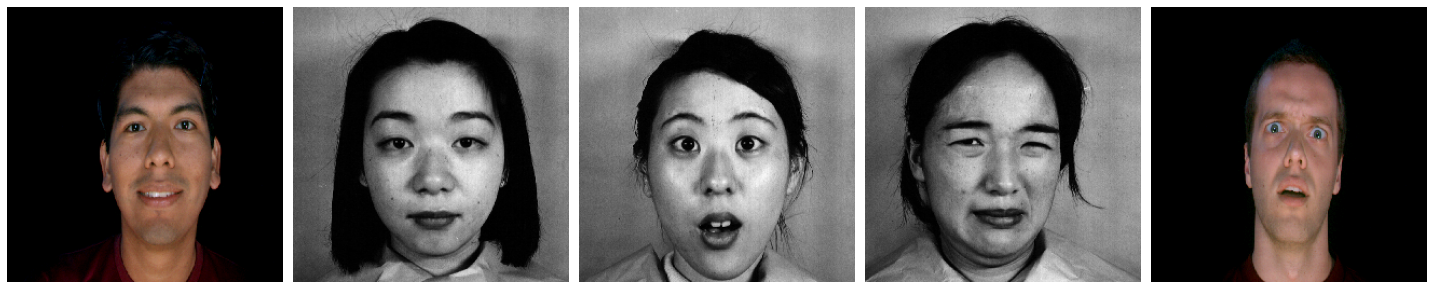

In [0]:
plotImages(sample[:5])

In [8]:
# get model to extract features
feature_extractor = keras.applications.VGG16(weights="imagenet", input_shape = (256, 256, 3),  include_top=False)

58892288/58889256 [==============================] - 1s 0us/step


In [0]:
x = keras.applications.vgg16.preprocess_input(sample[:5])
x_conv = feature_extractor.predict(
    x,
    batch_size = 1
)

In [0]:
x_conv[0].shape

(8, 8, 512)

In [9]:
# create model
model = keras.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim = 3))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy"
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 7)                

In [11]:
flatten = layers.Flatten()(feature_extractor.outputs)
classifier_1 = layers.Dense(512, activation="relu")(flatten)
classifier_2 = layers.Dense(256, activation="relu")(classifier_1)
output = layers.Dense(7, activation="softmax")(classifier_2)

for layer in feature_extractor.layers:
  layer.trainable = False

model_2 = keras.Model(inputs=feature_extractor.inputs, outputs=output)

model_2.compile(
    optimizer="adam",
    loss="categorical_crossentropy"
)

model_2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0   

In [12]:
model_2.fit(
    x = feature_dataframe,
    y = target_dataframe,
    batch_size = 1,
    epochs = 10,
    validation_split = 0.2
)

Train on 372 samples, validate on 93 samples
Epoch 1/10
372/372 [==============================] - 373s 1s/step - loss: 2.8389 - val_loss: 1.9832
Epoch 2/10
372/372 [==============================] - 383s 1s/step - loss: 1.9358 - val_loss: 1.9375
Epoch 3/10
372/372 [==============================] - 382s 1s/step - loss: 1.8969 - val_loss: 1.9264
Epoch 4/10
372/372 [==============================] - 388s 1s/step - loss: 1.8583 - val_loss: 1.9224
Epoch 5/10
372/372 [==============================] - 378s 1s/step - loss: 1.8979 - val_loss: 1.9503
Epoch 6/10
372/372 [==============================] - 378s 1s/step - loss: 1.8788 - val_loss: 1.8460
Epoch 7/10
372/372 [==============================] - 374s 1s/step - loss: 1.7954 - val_loss: 1.8222
Epoch 8/10
372/372 [==============================] - 375s 1s/step - loss: 1.7617 - val_loss: 1.8529
Epoch 9/10
372/372 [==============================] - 376s 1s/step - loss: 1.7040 - val_loss: 1.8574
Epoch 10/10
372/372 [=========================

In [17]:
testIm = cv2.imread("S010_002_01593900.png")
testIm = cv2.resize(testIm, (256, 256))
testIm = numpy.reshape(testIm, [1, 256, 256, 3])
classes = model_2.predict(testIm)

print (classes)

[[0.0000000e+00 0.0000000e+00 0.0000000e+00 9.9999976e-01 0.0000000e+00
  0.0000000e+00 2.3723570e-07]]


In [18]:
model_json = model_2.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# # load json and create model
# json_file = open('model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("model.h5")
# print("Loaded model from disk")
#
# # evaluate loaded model on test data
# loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
# score = loaded_model.evaluate(X, Y, verbose=0)
# print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))